In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

np.random.seed(42)

# --- 1) Synthetic "flight telemetry" dataset ---
n = 4000

df = pd.DataFrame({
    "altitude_m": np.random.normal(2500, 900, n).clip(0),
    "speed_mps": np.random.normal(70, 18, n).clip(0),
    "accel_mps2": np.random.normal(0, 2.5, n),
    "yaw_rate_dps": np.random.normal(0, 15, n),
    "wind_mps": np.random.normal(6, 4, n).clip(0),
    "gps_hdop": np.random.normal(1.2, 0.6, n).clip(0.3, 6),
    "battery_v": np.random.normal(15.2, 0.7, n).clip(12, 17),
    "temp_c": np.random.normal(22, 8, n),
})

# Create a target: "unstable_event" (proxy for risk/instability)
# Intuition: higher wind + yaw_rate + accel + low battery + poor GPS accuracy => more instability
risk_score = (
    0.20 * df["wind_mps"] +
    0.06 * np.abs(df["yaw_rate_dps"]) +
    0.10 * np.abs(df["accel_mps2"]) +
    0.35 * (16 - df["battery_v"]) +
    0.30 * (df["gps_hdop"] - 1.0)
)

prob = 1 / (1 + np.exp(-(risk_score - np.median(risk_score))))
df["unstable_event"] = (np.random.rand(n) < prob).astype(int)

df.head(), df["unstable_event"].mean()


(    altitude_m  speed_mps  accel_mps2  yaw_rate_dps  wind_mps  gps_hdop  \
 0  2947.042738  54.457115   -0.082563     17.622211  9.517229  1.408972   
 1  2375.562129  69.438337   -1.259126    -28.184714  6.157237  1.369994   
 2  3082.919684  70.324304   -0.430937     -4.916926  2.350698  0.638088   
 3  3870.726871  78.507346    1.786829     -0.624900  4.150003  1.547751   
 4  2289.261963  45.396549    3.194642      0.238630  7.371414  0.305950   
 
    battery_v     temp_c  unstable_event  
 0  14.730039  36.124742               1  
 1  14.700340  27.444404               1  
 2  16.197784  27.394394               0  
 3  16.505090  14.820587               0  
 4  14.549782  36.152496               0  ,
 np.float64(0.51675))

In [2]:
#  EDA
df.describe()


,altitude_m,speed_mps,accel_mps2,yaw_rate_dps,wind_mps,gps_hdop,battery_v,temp_c,unstable_event
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2517.803584,69.527722,-0.027997,0.362406,6.198924,1.206341,15.201885,21.871807,0.516750
std,896.224393,18.302175,2.476484,15.112391,3.776085,0.562806,0.687410,8.023662,0.499782
min,0.000000,3.609425,-9.806001,-54.528003,0.000000,0.300000,12.753468,-6.262546,0.000000
25%,1913.506641,57.250762,-1.660125,-9.855111,3.358559,0.773218,14.726817,16.465287,0.000000
50%,2518.756088,69.450554,-0.030487,0.376140,6.112871,1.185645,15.207574,21.868124,1.000000
75%,3105.647138,82.101713,1.611727,10.515181,8.837514,1.597159,15.664728,27.475529,1.000000
max,6033.613936,133.522993,8.444421,67.186264,21.769324,3.366810,17.000000,51.532996,1.000000


In [3]:
# Introduce missing values (to demonstrate preprocessing)
df_missing = df.copy()
for col in ["wind_mps", "gps_hdop", "temp_c"]:
    idx = np.random.choice(df_missing.index, size=int(0.03*n), replace=False)
    df_missing.loc[idx, col] = np.nan

df_missing.isna().mean()


altitude_m        0.00
speed_mps         0.00
accel_mps2        0.00
yaw_rate_dps      0.00
wind_mps          0.03
gps_hdop          0.03
battery_v         0.00
temp_c            0.03
unstable_event    0.00
dtype: float64

In [4]:
# Simple imputation (median)
df_clean = df_missing.copy()
for col in ["wind_mps", "gps_hdop", "temp_c"]:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

df_clean.isna().sum()


altitude_m        0
speed_mps         0
accel_mps2        0
yaw_rate_dps      0
wind_mps          0
gps_hdop          0
battery_v         0
temp_c            0
unstable_event    0
dtype: int64

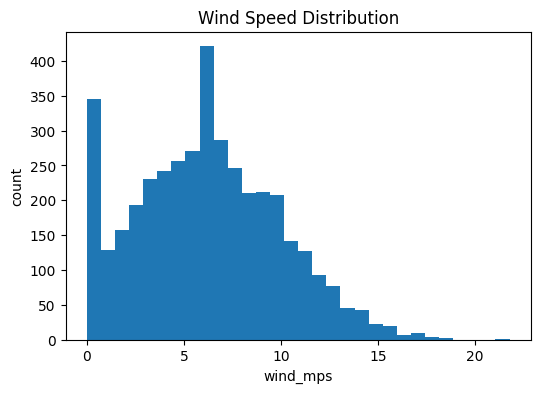

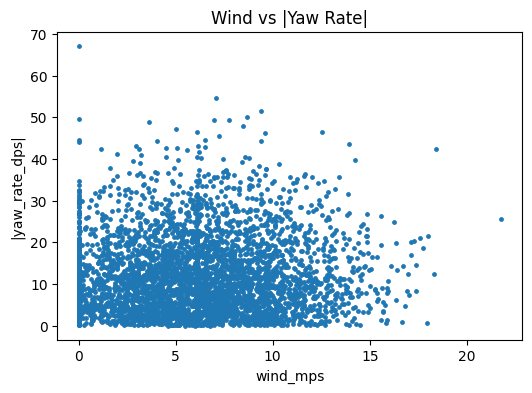

In [5]:
# Visualizations
fig = plt.figure(figsize=(6,4))
plt.hist(df_clean["wind_mps"], bins=30)
plt.title("Wind Speed Distribution")
plt.xlabel("wind_mps")
plt.ylabel("count")
plt.show()

fig = plt.figure(figsize=(6,4))
plt.scatter(df_clean["wind_mps"], np.abs(df_clean["yaw_rate_dps"]), s=6)
plt.title("Wind vs |Yaw Rate|")
plt.xlabel("wind_mps")
plt.ylabel("|yaw_rate_dps|")
plt.show()


In [6]:
# --- 3) Basic ML model ---
X = df_clean.drop(columns=["unstable_event"])
y = df_clean["unstable_event"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)

pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, pred))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))


ROC-AUC: 0.7153493377379858
              precision    recall  f1-score   support

           0       0.66      0.63      0.64       387
           1       0.67      0.70      0.68       413

    accuracy                           0.66       800
   macro avg       0.66      0.66      0.66       800
weighted avg       0.66      0.66      0.66       800

Confusion matrix:
 [[242 145]
 [124 289]]


In [7]:
# Feature impact (logistic regression coefficients)
coef = model.named_steps["clf"].coef_[0]
feat = pd.Series(coef, index=X.columns).sort_values(key=np.abs, ascending=False)
feat


wind_mps        0.770103
battery_v      -0.205167
gps_hdop        0.161193
temp_c          0.045664
speed_mps      -0.031279
yaw_rate_dps   -0.009113
accel_mps2     -0.008879
altitude_m     -0.008247
dtype: float64

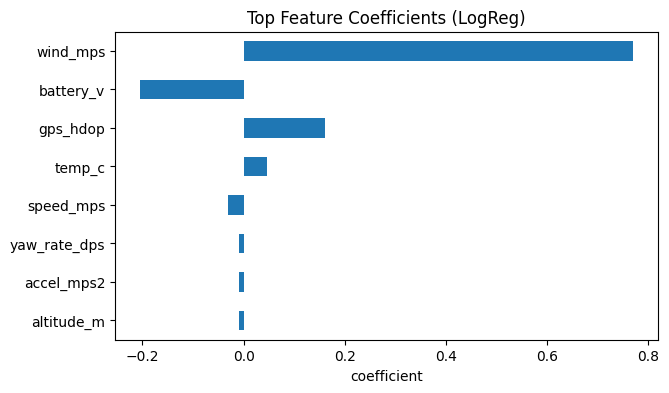

In [8]:
fig = plt.figure(figsize=(7,4))
feat.iloc[:8][::-1].plot(kind="barh")
plt.title("Top Feature Coefficients (LogReg)")
plt.xlabel("coefficient")
plt.show()
